In [1]:
import numpy as np

from helper_functions_tsp import read_file_name, validate_distance_array
from helper_functions_tsp import find_problem_size, cost_fn_fact
from helper_functions_tsp import read_index, hot_start
from helper_functions_tsp import convert_bit_string_to_cycle
from helper_functions_tsp import hot_start_list_to_string

from graph_functions import parameter_graph, cost_graph

from quantum_functions import define_parameters, create_initial_rotations
from quantum_functions import bind_weights, vqc_circuit, my_gradient, cost_func_evaluate


In [2]:
CONTROL_FILE = 'control/control_parameters.csv'
ENCODING = 'utf-8-sig'        #Encoding of csv file
GRAPH_DIRECTORY = 'graphs/'
LOCATIONS = 11                #number of locations to be visited

SHOTS = 1024                  #shots used for each call of the quantum circuit
EPSILON = np.pi/2             #constant for parameter shift
MODE = 2                      # MODE = 1 - rxgate, rygate, cnot gates
                              # MODE = 2 - rxgate, XX gates
ETA = 0.005                   #eta - learning rate for parameter shift
UPDATES = 2                   #updates, or iterations
PRINT_FREQUENCY = 1           #how often results are printed out
GRAY = False                  #Use Gray codes
HOT_START = True              #Make a hot start
VERBOSE = False               #controls how much is printedx
#SPSA = False                 #SPSA stochastic gradient descent used

## Read in the control file
The executions are controlled by a CSV parameter file in the control directory

In [3]:
control_dict = read_index(CONTROL_FILE, ENCODING)
print(control_dict)

{0: {'id': '0', 'locations': '5', 'mode': '1', 'eta': '0.005', 'updates': '50', 'print_frequency': '5', 'gray': '1', 'verbose': '1', 'optimiser': 'tbc'}, 1: {'id': '1', 'locations': '5', 'mode': '2', 'eta': '0.005', 'updates': '50', 'print_frequency': '5', 'gray': '1', 'verbose': '1', 'optimiser': 'tbc'}}


From the number of locations visited find the qubits and longest binary string.

In [4]:
bin_len, qubits = find_problem_size(LOCATIONS)
print(f'There are {qubits} qubits needed.  The longest binary string is {bin_len}')

There are 41 qubits needed.  The longest binary string is 4


Data sources are held locally to avoid downstream dependencies.

In [5]:
data_sources = {  4 : {'file' : 'data/four_d.txt', 'best' : 21},
                  5 : {'file' : 'data/five_d.txt', 'best' : 19},
                 11 : {'file' : 'data/dg11_d.txt', 'best' : 253},
                 15 : {'file' : 'data/p01_d.txt',  'best' : 291},
                 17 : {'file' : 'data/gr17_d.txt', 'best' : 2085},
                 26 : {'file' : 'data/fri26_d.txt', 'best' : 699},
                 42 : {'file' : 'data/dantzig42_d.txt', 'best' : 33_523},
                }

Read the data, and print out the filename and best distance held in the data.

In [6]:
filename = read_file_name(LOCATIONS, data_sources)
best_dist = data_sources[LOCATIONS]['best']
print(f'Data will be read from filename {filename}.  It is known that the shortest distance is {best_dist}.')

Data will be read from filename data/p01_d.txt.  It is known that the shortest distance is 291.


Read and validate the distance array.  This checks the array is the correct shape, and is symmetric.

In [7]:
distance_array = np.genfromtxt(filename)
validate_distance_array(distance_array, LOCATIONS)

Define the VQC circuits with appropriate parameters, and draw the circuit.

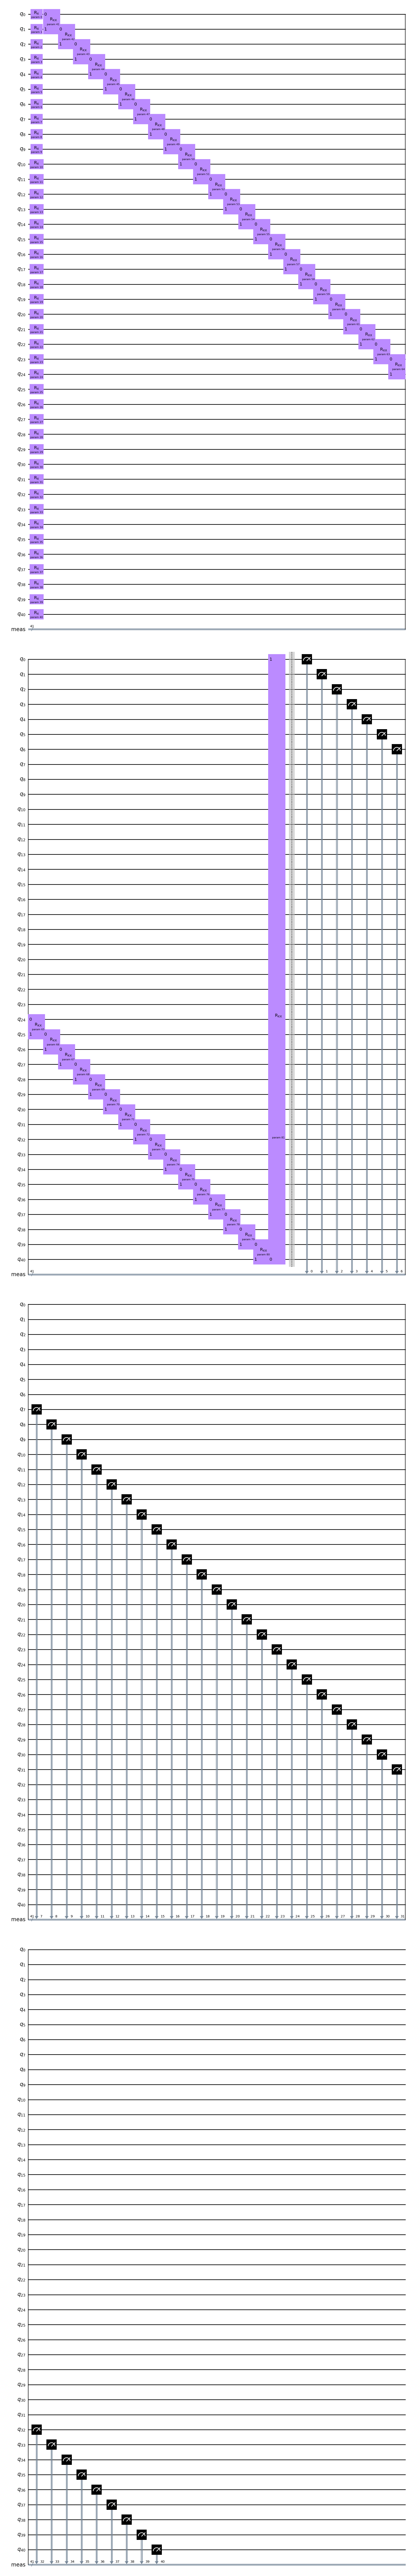

In [8]:
params = define_parameters(qubits, MODE)
qc = vqc_circuit(qubits, params, MODE)
qc.draw("mpl", style="clifford")

Iterate over the control parameters and do one experiment for each one of them.

Create random initial rotations, and bind these to the parameters in a new circuit `bc`.

hot_start_list [0, 12, 1, 14, 8, 4, 6, 2, 11, 13, 9, 7, 5, 3, 10]
bin_hot_start_list [1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0]
[3.141592653589793, 0, 3.141592653589793, 3.141592653589793, 0, 0, 0, 0, 3.141592653589793, 0, 3.141592653589793, 3.141592653589793, 0, 3.141592653589793, 3.141592653589793, 0, 0, 0, 3.141592653589793, 0, 0, 0, 3.141592653589793, 3.141592653589793, 0, 0, 0, 3.141592653589793, 0, 3.141592653589793, 3.141592653589793, 0, 3.141592653589793, 0, 3.141592653589793, 3.141592653589793, 3.141592653589793, 0, 0, 3.141592653589793, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


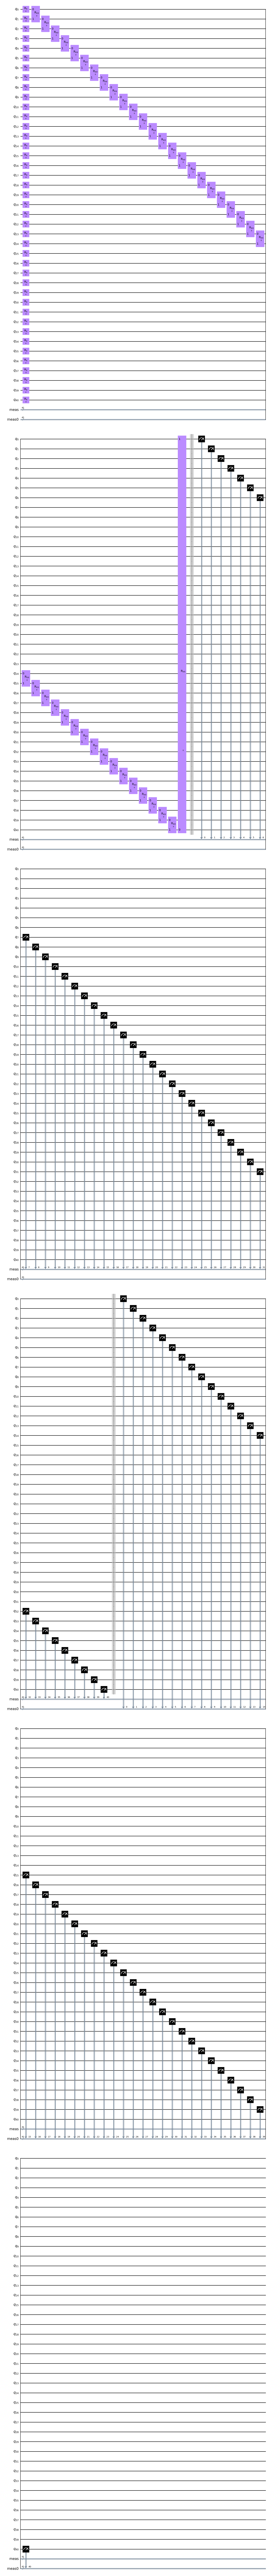

In [9]:
if HOT_START:
    hot_start_list = hot_start(distance_array, LOCATIONS)
    print(f'hot_start_list {hot_start_list}')
    bin_hot_start_list =  hot_start_list_to_string(hot_start_list, LOCATIONS, GRAY)
    print(f'bin_hot_start_list {bin_hot_start_list}')
    init_rots = create_initial_rotations(qubits, MODE, bin_hot_start_list, HOT_START)
else:
    init_rots = create_initial_rotations(qubits, MODE)
print(init_rots)
bc = bind_weights(params, init_rots, qc)
bc.measure_all()
bc.draw("mpl", style="clifford")

In [10]:
cost_fn = cost_fn_fact(LOCATIONS, distance_array, gray=GRAY, verbose=False)
cost_start, lowest_to_date, _ = cost_func_evaluate(cost_fn, bc, SHOTS)
print(f'For the starting circuit the average cost is {cost_start} and the lowest cost is {lowest_to_date}')

Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-168 using the statevector simulator. Required memory: 33554432M, max memory: 16111M


ValueError: could not broadcast input array from shape (0,6) into shape (1024,6)

In [11]:
rots = init_rots
cost_list, lowest_list, index_list, gradient_list = [], [], [], []
for i in range(UPDATES):
    bc = bind_weights(params, rots, qc)
    cost, lowest, lowest_energy_bit_string = cost_func_evaluate(cost_fn, bc, SHOTS)
    if i == 0:
        lowest_string_to_date = lowest_energy_bit_string
        lowest_to_date = lowest
    if lowest < lowest_to_date:
        lowest = lowest_to_date
        lowest_string_to_date = lowest_energy_bit_string
    route_list = convert_bit_string_to_cycle(lowest_string_to_date, LOCATIONS, gray=GRAY)
    index_list.append(i)
    cost_list.append(cost)
    lowest_list.append(lowest)
    gradient = np.array(my_gradient(cost_fn, qc, params, rots, EPSILON, SHOTS))
    gradient_list.append(gradient)
    if i % PRINT_FREQUENCY == 0:
        print(f'For iteration {i} the average cost from the sample is {cost} and the lowest cost from the sample is {lowest}')
        print(f'The lowest cost to date is {lowest_to_date} corresponding to bit string {lowest_string_to_date} ')
        print(f'and route {route_list}')
        if VERBOSE:
            print(f'The gradient is {gradient}')
    rots = rots - ETA * gradient

For iteration 0 the average cost from the sample is 19.0 and the lowest cost from the sample is 19.0
The lowest cost to date is 19.0 corresponding to bit string [0, 1, 0, 0, 1] 
and route [0, 2, 1, 4, 3]
For iteration 10 the average cost from the sample is 19.0 and the lowest cost from the sample is 19.0
The lowest cost to date is 19.0 corresponding to bit string [0, 1, 0, 0, 1] 
and route [0, 2, 1, 4, 3]
For iteration 20 the average cost from the sample is 19.0 and the lowest cost from the sample is 19.0
The lowest cost to date is 19.0 corresponding to bit string [0, 1, 0, 0, 1] 
and route [0, 2, 1, 4, 3]
For iteration 30 the average cost from the sample is 19.0 and the lowest cost from the sample is 19.0
The lowest cost to date is 19.0 corresponding to bit string [0, 1, 0, 0, 1] 
and route [0, 2, 1, 4, 3]
For iteration 40 the average cost from the sample is 19.0 and the lowest cost from the sample is 19.0
The lowest cost to date is 19.0 corresponding to bit string [0, 1, 0, 0, 1] 
an

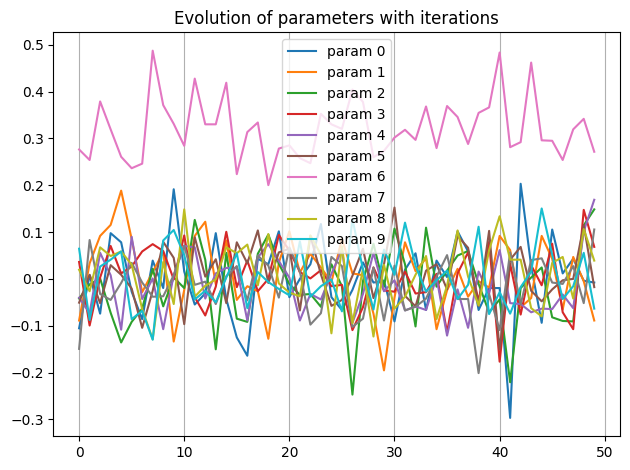

In [12]:
legend = [params[i].name for i, param in enumerate(params)] 
filename = GRAPH_DIRECTORY+f'Test'
parameter_graph(filename, index_list, gradient_list, legend)


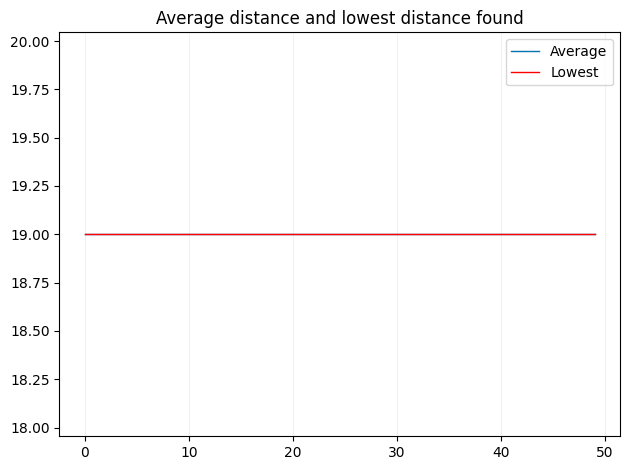

In [13]:
filename = GRAPH_DIRECTORY+f'Test2'
cost_graph(filename, index_list, cost_list, lowest_list)